# Plot filtered tf corrected external data
Compare external data ps with SAT ps

In [1]:
import matplotlib.pyplot as plt
from pixell import reproject, enmap, utils, enplot
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

#### Parameters

In [3]:
fsat = '150'
fplanck = '143'
SATp_type = '1'
beam_sat = 17.0  #24.8
calibration_factor_sat = 1. #0.86

In [4]:
# bins
binning_file = '/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/soopercool_inputs/binning_car_lmax2160_deltal15_large_first_bin.npz'
i_max_bin = 40  # kept only the first i_max_bin bins

In [5]:
# filtered cls
dir_cells = f'/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/filtered_data/planck/npipe6v20_A_B/satp{SATp_type}/f{fplanck}/soopercool_outputs/cells/'
data_sat_label = f'SATp{SATp_type}_f{fsat}_south_science'
data_ext_label = f'planck_f{fplanck}_filtered_SATp{SATp_type}_f{fsat}_south_science'
exp_pairs = [[f'{data_sat_label}',f'{data_sat_label}'], [f'{data_sat_label}',f'{data_ext_label}'], [f'{data_ext_label}',f'{data_ext_label}']]

In [6]:
# fiducial cmb
fiducial_cmb = '/scratch/gpfs/SIMONSOBS/users/ar3186/common/camb_spectra/cls_planck_TT_EE_BB_TE.fits'

In [7]:
# pix win to correct for
lmax_pix_win = 10000
pix_win_data_sat = np.ones(lmax_pix_win)
pix_win_data_ext = hp.pixwin(2048, pol=True, lmax=lmax_pix_win)[1]  # pix win in planck data

In [8]:
# beams to correct for
path_bl_ext = f'/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/data/planck/beams/beam_window_functions/beam_pol_{fplanck}.dat'
path_bl_sat = f'/scratch/gpfs/SIMONSOBS/users/ar3186/common/gauss_beams/beam_gauss_{beam_sat}amin.dat'

In [9]:
mode = 'EE'
imode_cmb = 1 # position of the selected mode in the cmb file
lmax_plot = 600
colors = ['blue', 'orange', 'green']
type = 'cross'

In [10]:
### Parameters for initial external data
data_init_ext_label = f'planck_f{fplanck}'
dir_initial_data = '/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/data'
exp = 'planck'
maps_type_A = 'npipe6v20A'
maps_type_B = 'npipe6v20B'
nside = 512
res = 1.0

### geometry template 
# (used to reproject the initial maps in the same geometry as the filtered coadded maps)
path_iso_geometry_template = '/home/ar3186/pwg-scripts/iso-sat-review/mapmaking/band_car_fejer1_5arcmin.fits'

### iso-sat analysis mask
# (used in soopercool to compute the TF corrected filtered coadded data ps)
path_iso_analysis_mask = f'/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/satp{SATp_type}/south/soopercool_outputs/science/masks/analysis_mask.fits'

path_maps_initial_data_hp_A = f'{dir_initial_data}/{exp}/maps/{maps_type_A}/{exp}_hp_{fplanck}_bundle0_nside{nside}_coords_c.fits'
path_maps_initial_data_hp_B = f'{dir_initial_data}/{exp}/maps/{maps_type_B}/{exp}_hp_{fplanck}_bundle1_nside{nside}_coords_c.fits'

#### Get pix win and beams to correct for

Note: as the beam for Planck is available to ell=1537 and as we are not interested to the small ells, each time that I use binning_edges (low, centers or high) or the cls I cut them at around 40.

In [ ]:
binning_edges = np.load(binning_file)
bin_centers_int = np.array(binning_edges['bin_center'][:i_max_bin], dtype=int)  # NOTE: this is exact only if bin centers are all integer values

In [12]:
bl_sat_from_disk = np.loadtxt(path_bl_sat, usecols=(0, 1), unpack=True)[1]
bl_ext = np.loadtxt(path_bl_ext, usecols=(0, 1), unpack=True)[1]

In [13]:
bl_sat_from_disk_centers = bl_sat_from_disk[bin_centers_int]
bl_ext = bl_ext[bin_centers_int]
pix_win_data_sat_centers = pix_win_data_sat[bin_centers_int]
pix_win_data_ext_centers = pix_win_data_ext[bin_centers_int]

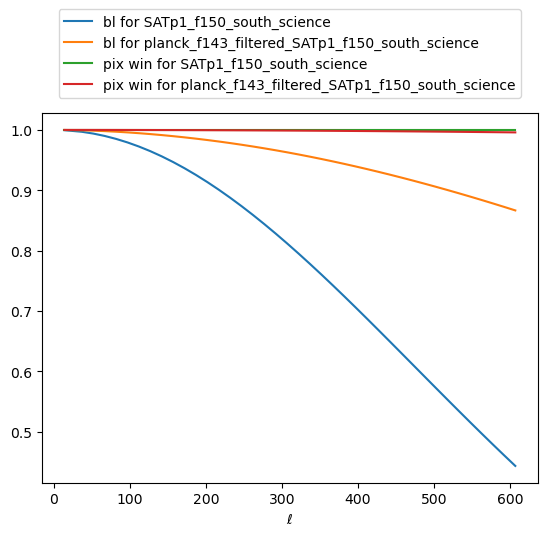

In [14]:
plt.plot(bin_centers_int, bl_sat_from_disk_centers, label=f'bl for {data_sat_label}')
plt.plot(bin_centers_int, bl_ext, label=f'bl for {data_ext_label}')

plt.plot(bin_centers_int, pix_win_data_sat_centers, label=f'pix win for {data_sat_label}')
plt.plot(bin_centers_int, pix_win_data_ext_centers, label=f'pix win for {data_ext_label}')

plt.xlabel(r'$\ell$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

In [15]:
bl_all = [bl_sat_from_disk_centers**2, bl_sat_from_disk_centers*bl_ext, bl_ext**2]
pix_win_all = [pix_win_data_sat_centers**2, pix_win_data_sat_centers*pix_win_data_ext_centers, pix_win_data_ext_centers**2]

In [16]:
calib_factors_all = [calibration_factor_sat**2, calibration_factor_sat*1.0, 1.0**2]

#### Get fiducial LCDM CMB

In [17]:
nmt_bins = nmt.NmtBin.from_edges(binning_edges["bin_low"][:i_max_bin], binning_edges["bin_high"][:i_max_bin] + 1)
lmax_bins = nmt_bins.get_ell_max(nmt_bins.get_n_bands() - 1)

In [18]:
cmb_cl = hp.read_cl(fiducial_cmb)[imode_cmb, :lmax_bins+1]
cmb_clb = nmt_bins.bin_cell(cmb_cl)

#### Get cls external data before filtering

In [19]:
# Maps initial external data full sky in hp
maps_initial_data_hp_A = hp.read_map(path_maps_initial_data_hp_A, field=(0,1,2))
maps_initial_data_hp_B = hp.read_map(path_maps_initial_data_hp_B, field=(0,1,2))

In [20]:
# reproject the initial hp map to car with the geometry from the iso template (band and 5amin) in car
shape, wcs = enmap.read_map_geometry(path_iso_geometry_template)
maps_initial_data_car_isogeo_A = reproject.healpix2map(maps_initial_data_hp_A, shape=shape, wcs=wcs)
maps_initial_data_car_isogeo_B = reproject.healpix2map(maps_initial_data_hp_B, shape=shape, wcs=wcs)

In [21]:
# load iso-sat analysis mask
analysis_mask_car = enmap.read_map(path_iso_analysis_mask)

In [22]:
# compute ps for initial external data in car and with the iso-sat geometry
field_pol_A = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_A[1], maps_initial_data_car_isogeo_A[2]], wcs=wcs, lmax=lmax_bins, lmax_mask=lmax_bins)
field_pol_B = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_B[1], maps_initial_data_car_isogeo_B[2]], wcs=wcs, lmax=lmax_bins, lmax_mask=lmax_bins)
cls_initial_pol = (nmt.compute_full_master(field_pol_A, field_pol_B, nmt_bins))

### Plot all cls : no beam corrections

(1e-06, 1.0)

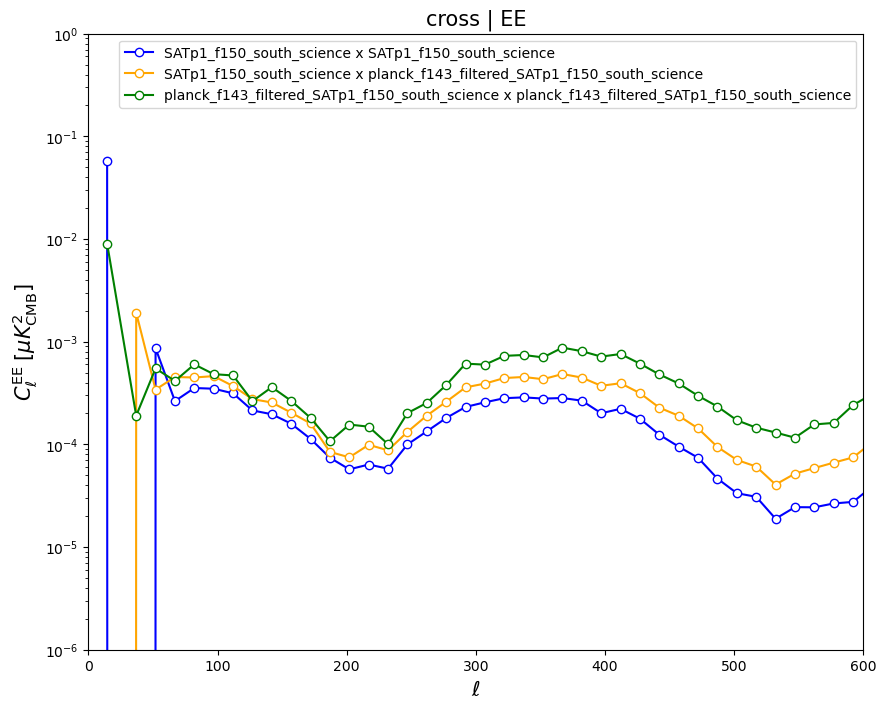

In [23]:
# w/o beams corrections
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

for iep, ep in enumerate(exp_pairs):
    path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{ep[0]}_x_{ep[1]}.npz'
    cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)

    plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])

# plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_initial_pol[0]*1e12/pix_win_all[2]/bl_all[2], label=f'{data_init_ext_label} x {data_init_ext_label} initial')

# plt.plot(cls_filtered_coadded_tf['lb'][:len(cmb_clb)], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)

### Plot all cls : with beam corrections and calibration correction (for SO)
Values for SO beams and calibration correction are passed by the user (e.g. I use the values from fitting the SO data to the Planck data for SO f090 and Planck f100).

(1e-06, 1.0)

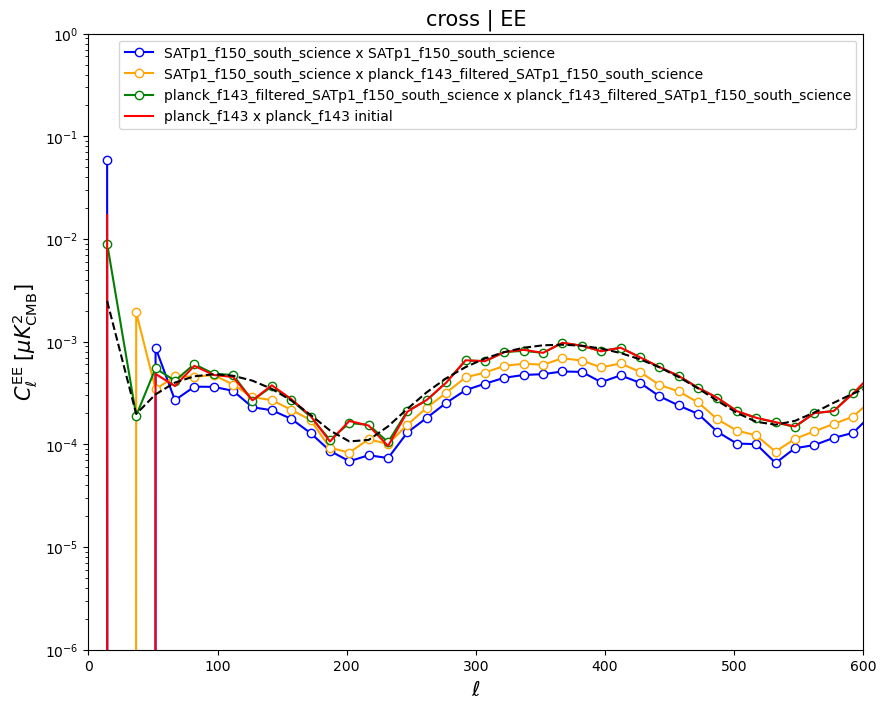

In [24]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

for iep, ep in enumerate(exp_pairs):
    path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{ep[0]}_x_{ep[1]}.npz'
    cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)

    plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/pix_win_all[iep]/bl_all[iep]/calib_factors_all[iep], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_initial_pol[0]*1e12/pix_win_all[2]/bl_all[2], label=f'{data_init_ext_label} x {data_init_ext_label} initial', color='red')

plt.plot(cls_filtered_coadded_tf['lb'][:len(cmb_clb)], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)

### Plot all cls : Fit for sat beam ON LCDM

In [25]:
i_bin_exclude_fit = 5

In [26]:
def data_model_sat_sat(cls_th, fwhm):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_th * bl[i_bin_exclude_fit:]**2

In [27]:
def data_model_sat_planck(cls_th, fwhm):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_th * bl[i_bin_exclude_fit:]

fit for SATp1_f150_south_science x SATp1_f150_south_science: 24.74460085334155 acmin
fit for SATp1_f150_south_science x planck_f143_filtered_SATp1_f150_south_science: 24.616677626764005 acmin


(1e-06, 1.0)

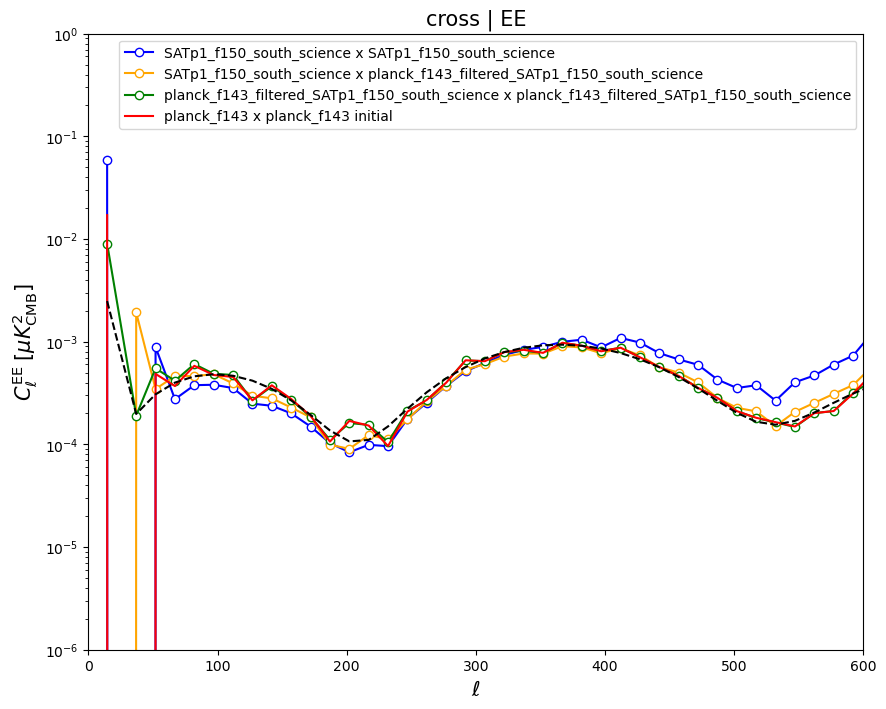

In [28]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

for iep, ep in enumerate(exp_pairs):
    path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{ep[0]}_x_{ep[1]}.npz'
    cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)

    if iep == 2:
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/pix_win_all[iep]/bl_all[iep], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])
    elif iep == 0:
        # fit the beam
        popt, pcov = curve_fit(data_model_sat_sat, cmb_clb[i_bin_exclude_fit:], cls_filtered_coadded_tf[mode][i_bin_exclude_fit:i_max_bin], p0=[np.deg2rad(30.0/60.0)])  # fwhm in rad
        print(f'fit for {ep[0]} x {ep[1]}: {np.rad2deg(popt[0])*60} acmin')
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int]**2, label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])
    elif iep == 1:
        # fit the beam
        popt, pcov = curve_fit(data_model_sat_planck, cmb_clb[i_bin_exclude_fit:], cls_filtered_coadded_tf[mode][i_bin_exclude_fit:i_max_bin]/pix_win_all[iep][i_bin_exclude_fit:]/bl_ext[i_bin_exclude_fit:], p0=[np.deg2rad(30.0/60.0)])  # fwhm in rad
        print(f'fit for {ep[0]} x {ep[1]}: {np.rad2deg(popt[0])*60} acmin')
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_initial_pol[0]*1e12/pix_win_all[2]/bl_all[2], label=f'{data_init_ext_label} x {data_init_ext_label} initial', color='red')

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)

### Plot all cls : Fit for sat beam and calibration factor ON LCDM

In [29]:
def data_model_sat_sat_beam_const(cls_th, fwhm, c):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_th * bl[i_bin_exclude_fit:]**2 * c

In [30]:
def data_model_sat_planck_beam_const(cls_th, fwhm, c):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_th * bl[i_bin_exclude_fit:] * c

fit for SATp1_f150_south_science x SATp1_f150_south_science: 19.667056174192055 acmin, 0.6719856346346984
fit for SATp1_f150_south_science x planck_f143_filtered_SATp1_f150_south_science: 20.071107931053657 acmin, 0.8107368627928259


(1e-06, 1.0)

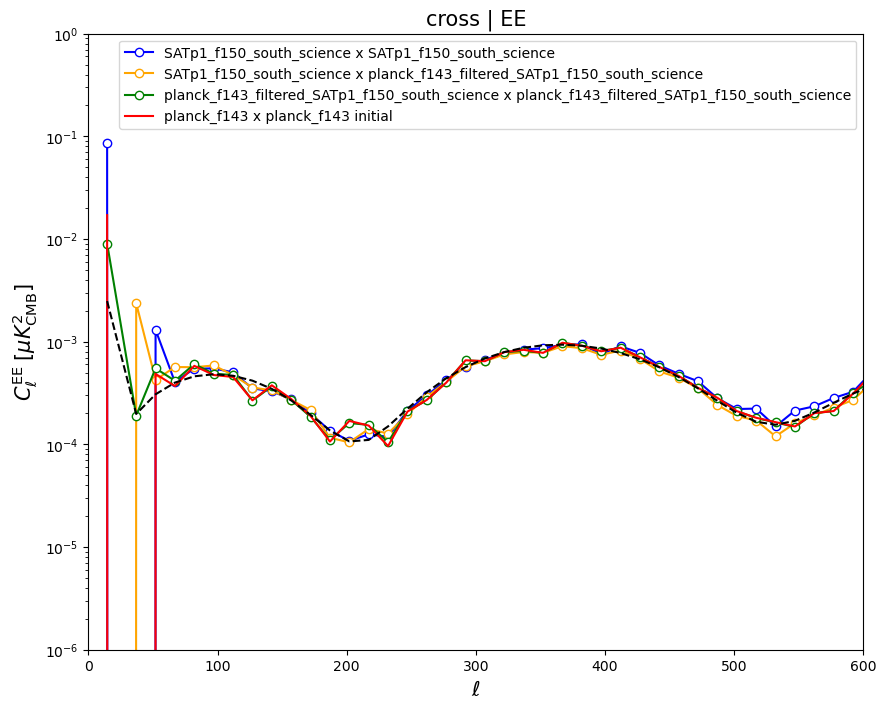

In [31]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

for iep, ep in enumerate(exp_pairs):
    path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{ep[0]}_x_{ep[1]}.npz'
    cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)

    if iep == 2:
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/pix_win_all[iep]/bl_all[iep], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])
    elif iep == 0:
        # fit the beam
        popt, pcov = curve_fit(data_model_sat_sat_beam_const, cmb_clb[i_bin_exclude_fit:], cls_filtered_coadded_tf[mode][i_bin_exclude_fit:i_max_bin], p0=[np.deg2rad(30.0/60.0), 1.])  # fwhm in rad
        print(f'fit for {ep[0]} x {ep[1]}: {np.rad2deg(popt[0])*60} acmin, {popt[1]}')
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int]**2 / popt[1], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])
    elif iep == 1:
        # fit the beam
        popt, pcov = curve_fit(data_model_sat_planck_beam_const, cmb_clb[i_bin_exclude_fit:], cls_filtered_coadded_tf[mode][i_bin_exclude_fit:i_max_bin]/pix_win_all[iep][i_bin_exclude_fit:]/bl_ext[i_bin_exclude_fit:], p0=[np.deg2rad(30.0/60.0), 1.])  # fwhm in rad
        print(f'fit for {ep[0]} x {ep[1]}: {np.rad2deg(popt[0])*60} acmin, {popt[1]}')
        plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_filtered_coadded_tf[mode][:i_max_bin]/hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int] / popt[1], label = f'{ep[0]} x {ep[1]}', mfc="w", marker="o", c=colors[iep])

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cls_initial_pol[0]*1e12/pix_win_all[2]/bl_all[2], label=f'{data_init_ext_label} x {data_init_ext_label} initial', color='red')

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)

### Plot all cls : Fit for sat beam and calibration factor ON Planck

In [32]:
def data_model_sat_sat_beam_fit_on_planck_fit_on_planck(cls_planck, fwhm, c):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_planck * bl[i_bin_exclude_fit:]**2 * c**2

In [33]:
def data_model_sat_planck_beam_const(cls_planck, fwhm, c):
    bl = hp.gauss_beam(fwhm=fwhm, lmax=lmax_bins, pol=False)[bin_centers_int]
    return cls_planck * bl[i_bin_exclude_fit:] * c

fit for SATp1_f150_south_science x SATp1_f150_south_science: 20.10887337697083 acmin, 0.8398270042592872
fit for SATp1_f150_south_science x planck_f143_filtered_SATp1_f150_south_science: 21.058701751938013 acmin, 0.8552666226961052


(1e-06, 1.0)

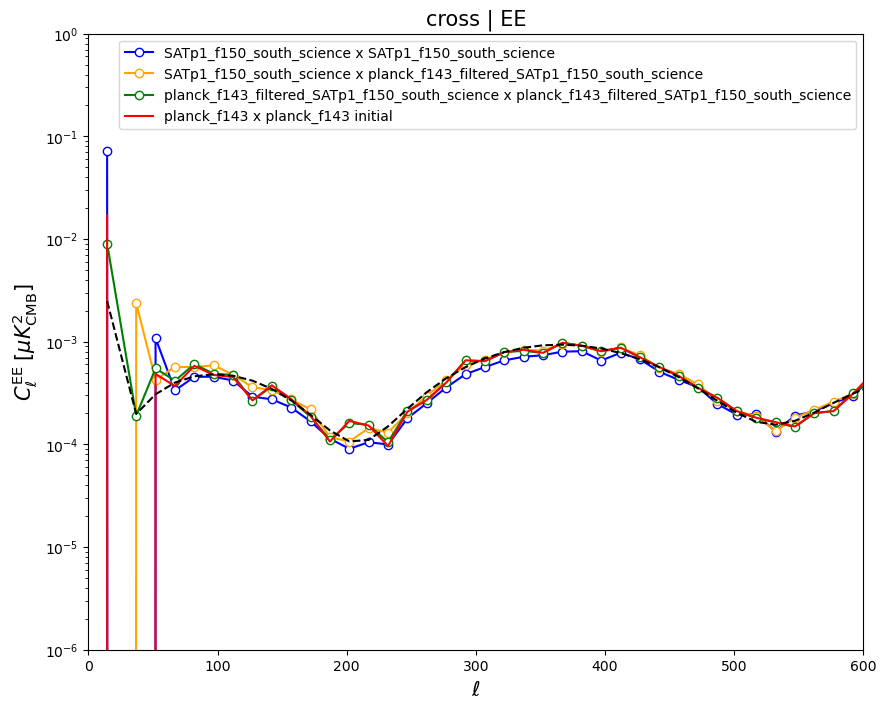

: 

In [ ]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)


## Planck Placnk
path_cls_planck_planck = f'decoupled_{type}_pcls_{exp_pairs[2][0]}_x_{exp_pairs[2][1]}.npz'
file_cls_planck_planck = np.load(dir_cells + path_cls_planck_planck)
ell_bins = file_cls_planck_planck['lb'][:i_max_bin]
cls_planck_planck = file_cls_planck_planck[mode][:i_max_bin]/(pix_win_data_ext_centers**2)/(bl_ext**2)

## SAT SAT
path_cls_sat_sat = f'decoupled_{type}_pcls_{exp_pairs[0][0]}_x_{exp_pairs[0][1]}.npz'
file_cls_sat_sat = np.load(dir_cells + path_cls_sat_sat)
cls_sat_sat = file_cls_sat_sat[mode][:i_max_bin]
popt_sat_sat, _ = curve_fit(
    data_model_sat_sat_beam_fit_on_planck_fit_on_planck, 
    cls_planck_planck[i_bin_exclude_fit:], 
    cls_sat_sat[i_bin_exclude_fit:], 
    p0=[np.deg2rad(30.0/60.0), 1.])  # fwhm in rad
print(f'fit for {exp_pairs[0][0]} x {exp_pairs[0][1]}: {np.rad2deg(popt_sat_sat[0])*60} acmin, {popt_sat_sat[1]}')
bl_sat_fit = hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int]
plt.plot(ell_bins, 
         cls_sat_sat/ bl_sat_fit**2 / popt[1], 
         label = f'{exp_pairs[0][0]} x {exp_pairs[0][1]}', 
         mfc="w", marker="o", c=colors[0])  #lw=0.7,

## SAT Planck
path_cls_sat_planck = f'decoupled_{type}_pcls_{exp_pairs[1][0]}_x_{exp_pairs[1][1]}.npz'
file_cls_sat_planck = np.load(dir_cells + path_cls_sat_planck)
cls_sat_planck = file_cls_sat_planck[mode][:i_max_bin] / pix_win_data_ext_centers / bl_ext
popt_sat_planck, _ = curve_fit(
    data_model_sat_planck_beam_const, 
    cls_planck_planck[i_bin_exclude_fit:], 
    cls_sat_planck[i_bin_exclude_fit:], 
    p0=[np.deg2rad(30.0/60.0), 1.])  # fwhm in rad
print(f'fit for {exp_pairs[1][0]} x {exp_pairs[1][1]}: {np.rad2deg(popt_sat_planck[0])*60} acmin, {popt_sat_planck[1]}')
bl_sat_fit2 = hp.gauss_beam(fwhm=popt[0], lmax=lmax_bins, pol=False)[bin_centers_int]
plt.plot(ell_bins, 
         cls_sat_planck / bl_sat_fit2 / popt[1], 
         label = f'{exp_pairs[1][0]} x {exp_pairs[1][1]}', 
         mfc="w", marker="o", c=colors[1])



plt.plot(ell_bins, cls_planck_planck, label = f'{exp_pairs[2][0]} x {exp_pairs[2][1]}', mfc="w", marker="o", c=colors[2])

plt.plot(ell_bins[:i_max_bin], cls_initial_pol[0]*1e12/pix_win_all[2]/bl_all[2], label=f'{data_init_ext_label} x {data_init_ext_label} initial', color='red')

plt.plot(ell_bins, cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)